In [7]:
%load_ext autoreload
%autoreload 2

try:
    from main import *
    from bpe import BPE, ByteTokenizer
except ImportError:
    # We are on colab, we need to paste main.py in a cell below
    pass

from dataclasses import dataclass, field
from pathlib import Path
from pprint import pprint
from typing import Iterator, Tuple, List
from time import time
from collections import Counter
import random

import torch
from torch import tensor
import jsonlines
import matplotlib.pyplot as plt

# %load_ext line_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%pip install einops torchtyping  # not on kaggle nor colab

In [1]:
# DATA = Path('/extra/diego/the-pile/')
# DATASET = '29.jsonl'
DATA = Path('.')
DATASET = 'small-pile.jsonl'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device {device}')

Using device cuda


In [2]:
def dataset(deterministic=True, max_length=1_000_000, file_name: str = DATASET) -> Iterator[str]:
    total_length = 0
    while True:
        for doc in jsonlines.open(DATA / file_name):
            doc = doc['text'] if isinstance(doc, dict) else doc
            if deterministic or (not deterministic and random.random() < 0.01):
                total_length += len(doc)
                if total_length > max_length > 0:
                    doc = doc[:max_length - total_length]
                yield doc

            if total_length >= max_length > 0:
                return


def get_text(length: int, from_=dataset(False, -1)) -> str:
    text = ''
    while len(text) < length:
        text += next(from_)
    return text[:length]

sum(map(len, dataset()))

1000000

# Tokenizer


In [ ]:
bpe = BPE.train_from_text(dataset(), 10000, 2)
bpe.save(input('Save to:') + '.pt')

In [ ]:
bpe = BPE.load('bpe.pt')

In [ ]:
pprint(bpe.token_frequencies)

## Performance


In [ ]:
import timeit

bpe = BPE.load('bpe.pt')

In [ ]:
# Compute time per call for different batch sizes and text sizes
results = {}
for batch_size in [1, 10, 100]:
    results[batch_size] = {}
    for text_size in range(2, 10):
        text_size = 4**text_size
        if text_size * batch_size > 10**6:
            continue
        # Start with a small number of runs
        num_runs = 5
        t = 0.0
        while t < 0.2:
            # Time the function call using the current number of runs
            t = timeit.timeit("bpe.tokenize(texts)",
                              setup="texts = [get_text(text_size) for _ in range(batch_size)]",
                              globals=globals(),
                              number=num_runs)
            # Double the number of runs for the next iteration
            num_runs *= 2
        # Store the time and number of runs in the results dictionary
        results[batch_size][text_size] = (t / num_runs, num_runs)
        print(f'batch_size={batch_size}, text_size={text_size}: {t / num_runs:.4f}s per call')

In [ ]:
# Plot results
for block_size, data in results.items():
    xs = [block_size * b for b in data]
    ys = [t for t, _ in data.values()]
    plt.loglog(xs, ys, label=f'batch_size={block_size}')
plt.legend()
plt.xlabel('Total text size')
plt.ylabel('Time per call (s)')


## Comparison with gpt2 tokenizer


In [ ]:
# Print all tokens in GPT-2 vocabulary
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt_tokens = [tokenizer.decode([i]) for i in range(tokenizer.vocab_size)]

In [ ]:
' Python' in gpt_tokens

# Training


In [300]:
@dataclass
class Perfs:
    loss: List[float] = field(default_factory=list)

    def plot(self, smoothing=10, log=False, last=-1):
        if last > 0:
            loss = self.loss[-last:]
        else:
            loss = self.loss
        smoothed = torch.conv1d(torch.tensor(loss).unsqueeze(0),
                                     torch.ones(1,1, smoothing) / smoothing).squeeze()
        if log:
            plt.semilogy(smoothed.numpy())
        else:
            plt.plot(smoothed.numpy())
        plt.xlabel('Batch')
        plt.ylabel('Loss')


# @typechecked
def train(model,
          optim,
          data_generator: Iterator[Tuple[TT['batch', 'token', int], TT['batch', 'token', int]]],
          batch_size: int = 32,
          max_time: float = 60.0,
          perfs: Perfs = None):
    if perfs is None:
        perfs = Perfs()

    model.train()
    tokens_processed = 0
    lost = sum(perfs.loss[-100:]) / 100
    start_time = time()
    while time() - start_time < max_time:
        optim.zero_grad()

        # Build the batch
        xs, ys = zip(*(next(data_generator) for _ in range(batch_size)))
        xs = torch.stack(xs).to(device)
        ys = torch.stack(ys).to(device)

        loss = model.loss(xs, ys)
        loss.backward()
        optim.step()

        tokens_processed += xs.numel()
        perfs.loss.append(loss.item())
        lost = 0.99 * lost + 0.01 * loss.item()
        if len(perfs.loss) % 100 == 0:
            print(f'Batch {len(perfs.loss)} loss: {lost:.4f} ({tokens_processed / (time() - start_time):.0f} tokens/s)')

    return perfs

## Case recover model


In [4]:
embedding_dim = 128
block_size = 100
head_count = 4
depth = 8

model = UpcaseTransformer(embedding_dim, depth=depth, head_count=head_count, block_size=block_size)
model.to(device)
perfs = Perfs()
optim = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [5]:
# Dataset generator

if True:
    data = '\n'.join(dataset(False))
    data = data.encode('utf-8')
    data = tensor(list(data), dtype=int).to(device)

def upcase_dataset(block_size: int) -> Iterator[Tuple[TT['token', int], TT['token', int]]]:
    while True:
        pos = random.randint(0, len(data) - block_size)
        batch: TT['token', int] = data[pos:pos + block_size]

        upper = (batch >= ord('A')) & (batch <= ord('Z'))
        prompt = batch.clone()
        prompt[upper] += 32
        yield prompt, upper.long()

In [140]:
# Find the proportion of uppercase letters in the dataset
total = 0
upcase = 0
for doc in dataset(False, 1_000_000):
    total += len(doc)
    upcase += sum(1 for c in doc if c.isupper())
up = upcase / total
low = 1 - up

print("Proportion of uppercase letters:", up)
print("Proportion of lowercase letters:", low)
print("Weight of upcase:", 1 / up)
print("Weight of lowcase:", 1 / low)

Proportion of uppercase letters: 0.036411
Proportion of lowercase letters: 0.963589
Weight of upcase: 27.464227843234188
Weight of lowcase: 1.0377868572596822


In [18]:
optim = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)  

In [142]:
loss = sum(perfs.loss[-100:]) / 100
torch.save(model, f'upcase_{loss:.4f}.pt')

Batch 35500 loss: 0.0086 (214746 tokens/s)


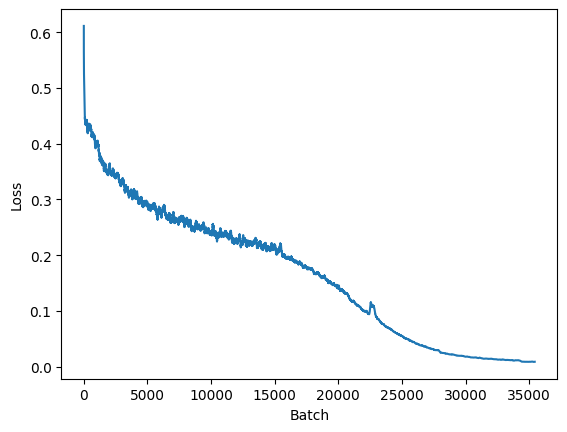

In [420]:
train(model, optim, upcase_dataset(block_size), batch_size=1000, max_time=50, perfs=perfs)
loss = sum(perfs.loss[-100:]) / 100
# torch.save(model, f'upcase_{loss:.4f}.pt')
perfs.plot(100, last=6000)

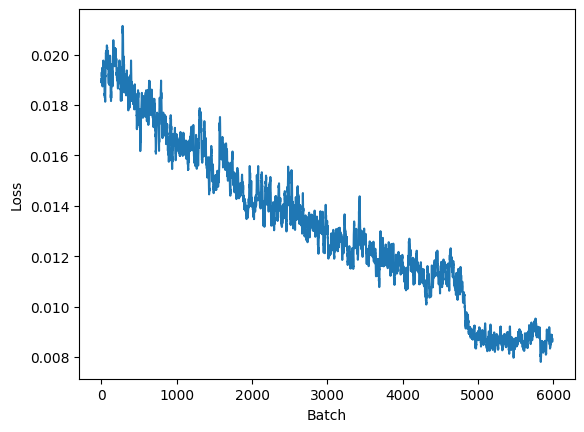

In [422]:
perfs.plot(10, log=0, last=6000)
# plt.semilogy(perfs.loss[-4000:])

In [419]:
# Check if it works
pos = random.randint(0, len(data) - block_size)
d = data[pos:pos + block_size]
text = bytes(d).decode(errors='replace')

print(f"Prompt: {text.lower()!r}")
print(f"Expect: {text!r}")

out = repr(model.predict(text.lower()))
probas = model(ByteTokenizer.tokenize([text.lower()], block_size))[0]

diffs = ''.join(' ' if a == b else '^' for a, b in zip(repr(text), out))
bad_diffs = ''.join(' u'[b.isupper()] for b in out)

print(f"Output: {out}")
print(f"Errors: {diffs}")
print(f"Upcase: {bad_diffs}")
print(diffs[10:-10].count('^'), 'differences')
probas = probas.softmax(1)

Prompt: 'd district attorney jeff rosen’s decision to pursue the death penalty.\n\noutside the hall of justic'
Expect: 'd District Attorney Jeff Rosen’s decision to pursue the death penalty.\n\nOutside the Hall of Justic'
Output: 'd District Attorney Jeff Rosen’s decision to pursue the death penalty.\n\nOutside the Hall of Justic'
Errors:                                                                                                       
Upcase:    u        u        u    u                                                u           u       u      
0 differences


In [133]:
# Size of the model
sum(p.numel() for p in model.parameters())

1628162

In [ ]:
with jsonlines.open(DATA / 'small-pile-2.jsonl', 'w') as writer:
    for doc in dataset():
        writer.write({'text': doc})

## Prompt-O-Matic v1

In [ ]:
block_size = 100
embedding_dim = 128
model = PromptOMaticV1(
    embedding_dim=embedding_dim,
    depth=6,
    head_count=4,
    block_size=100,
)
model.to(device)
perfs = Perfs()
optim = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [ ]:
optim = torch.optim.AdamW(model.parameters(), lr=5e-4)

In [ ]:
data = '\n'.join(dataset(False, 100_000_000))
data = data.encode('utf-8')
data = tensor(list(data), dtype=int).to(device)

def promptomatic_dataset(block_size: int):
    while True:
        pos = random.randint(0, len(data) - block_size - 1)
        xs: TT['token', int] = data[pos:pos + block_size]
        ys = data[pos + 1:pos + block_size + 1]
        yield xs, ys

In [ ]:
frequencies = Counter(data)

In [ ]:
from main import PromptOMaticV1
model.__class__ = PromptOMaticV1

model.generate('The most important problem in the world is', 300, beams=3, n=1)

In [ ]:
model.generate('Tanguy: Hello, ', 200, beams=3)

In [ ]:
train(model, optim, promptomatic_dataset(block_size), max_time=600, perfs=perfs)

print(model.generate('Hey Diego, do you ', 100, beams=1))
print(torch.tensor(perfs.loss[-40:]).mean().item())
Perfs.plot(perfs, 42)

In [ ]:
Perfs.plot(perfs, 1)

In [ ]:
# Parameters count
sum(p.numel() for p in model.parameters())

# Interpretability

In [ ]:
model = PromptOMaticV1(128, 4, 4, 100)
model.load_state_dict(torch.load('./the BOMP 1.58 .pt'))

In [ ]:
# Visualizing the positional embeddings
import matplotlib.pyplot as plt

pos_emb = model.positional_embedding.weight.detach().cpu()
tok_emb = model.embedding.weight.detach().cpu()

cos_similarities = pos_emb @ pos_emb.T
plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
plt.imshow(pos_emb[1:])
plt.colorbar()
# plt.subplot(1, 2, 2)
# plt.imshow(cos_similarities[1:, 1:])
# plt.colorbar()

In [ ]:
def plot_std_var(emb, dim=0):
    xs = emb.mean(dim)
    ys = emb.std(dim)
    plt.scatter(xs, ys, c=range(len(xs)))
    plt.xlabel('mean')
    plt.ylabel('std')
    plt.colorbar()

def plot_both(emb1, emb2, op='std', name1='positional', name2='token'):
    xs = getattr(emb1, op)(0)
    ys = getattr(emb2, op)(0)
    plt.scatter(xs, ys, c=range(len(xs)))
    plt.xlabel(name1)
    plt.ylabel(name2)
    plt.title(f'{op}({name1}) vs {op}({name2})')
    plt.colorbar()

pos_emb = model.positional_embedding.weight.detach().cpu()
tok_emb = model.embedding.weight.detach().cpu()

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.title('Positional embedding')
plot_std_var(pos_emb)
plt.subplot(2, 2, 2)
plot_std_var(tok_emb)
plt.title('Token embedding')

plt.subplot(2, 2, 3)
plot_both(pos_emb, tok_emb, 'mean')
plt.subplot(2, 2, 4)
plot_both(pos_emb, tok_emb, 'std')



In [ ]:
# Create an identity matrix with its diagonal spread out

spread_eye = torch.zeros(100, 100)
spread = 6
for i in range(-spread, spread):
    spread_eye += torch.diag(torch.ones(100 - abs(i)), i) * (1.5 / (abs(i + 0.5) + 1))

a = torch.cat([
    torch.zeros(pos_emb.shape[0], pos_emb.shape[1] - 50),
    spread_eye[:, ::2]
], dim=1)
a[0, 128-50] = 4
plt.imshow(a)
plt.colorbar()

In [ ]:
model.positional_embedding.weight = torch.nn.Parameter(a.to(device))
perfs = Perfs()
optim = torch.optim.AdamW(model.parameters(), lr=1e-4)
model.generate("My name is", 100)

In [ ]:
train(model, optim, promptomatic_dataset(100), max_time=60, perfs=perfs)
print(model.generate("My name is", 100, beams=3))
perfs.plot(42)

In [ ]:
original = PromptOMaticV1(128, 4, 4, 100)
original.load_state_dict(torch.load('./the BOMP 1.58 .pt'))
probs = original.forward(ByteTokenizer.tokenize(["Alice and Bob are at Christmas, Alice gives a present to "]))
print(probs)

In [ ]:
ps = probs[0, -1].softmax(0)
ps[ord('A')], ps[ord('B')]

In [ ]:
a[a.abs() < 0.1] = 0